# Выбор локации для скважины

`Цель:`  добывающей компании «N» необходимо решить,  новую скважину

`Задача:` построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

`Входные данные:` пробы нефти в трёх регионах: в каждом из 10 000 месторождений.  качество нефти и объём её запасов.


`Описание данных:`
Данные геологоразведки трёх регионов находятся в файлах:
- /datasets/geo_data_0.csv.
- /datasets/geo_data_1.csv. 
- /datasets/geo_data_2.csv. 

`id` — уникальный идентификатор скважины;
`f0, f1, f2` — три признака точек;
`product` — объём запасов в скважине (тыс. баррелей).


`Условия задачи:`
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

`Этапы исследования:`
1. Загрузка и подготовка данные. 
2. Обучение и проверка моделей для каждого региона:
3. Подготовка к расчёту прибыли:
4. Написание функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
5. Расчет рисков и прибыли для каждого региона:
6. Вывод

## Загрузка и подготовка данных

### Подключение библиотек

In [1]:
# Импорт библиотек и методов
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import warnings

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression 

In [2]:
# Игнорирование предупреждений
warnings.filterwarnings('ignore')

### Загрузка данных и основная информация

In [3]:
# Загрузка данных
geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
#geo_0.head()
#geo_1.head()
geo_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [5]:
# Удаление лишнего признака

geo_0 = geo_0.drop(['id'],axis=1)
geo_1 = geo_1.drop(['id'],axis=1)
geo_2 = geo_2.drop(['id'],axis=1)

In [6]:
# Основная информация о таблицах

#geo_0.info()
#geo_1.info()
geo_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


In [7]:
# Статистическая информация о таблицах

geo_0.describe()
#geo_1.describe()
#geo_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


### Проверка данных на пропуски, дубликаты и аномалии

In [8]:
print(geo_0.isna().sum()) # подсчёт пропусков
print(geo_1.isna().sum())
print(geo_2.isna().sum())

f0         0
f1         0
f2         0
product    0
dtype: int64
f0         0
f1         0
f2         0
product    0
dtype: int64
f0         0
f1         0
f2         0
product    0
dtype: int64


In [9]:
print(geo_0.duplicated().sum()) # подсчет дубликатов
print(geo_1.duplicated().sum())
print(geo_2.duplicated().sum())

0
0
0


Дубликаты и пропуски отсутствуют, проверим данные на выбросы.

f0


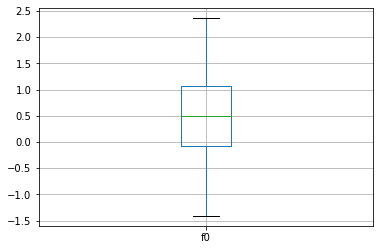

f1


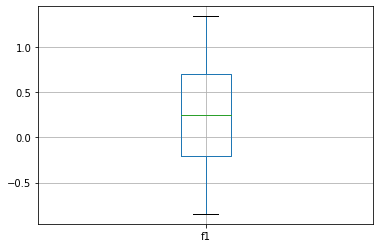

f2


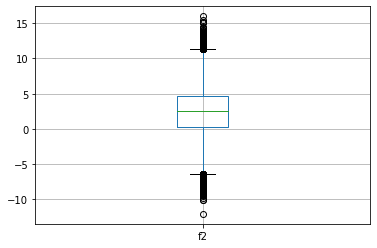

product


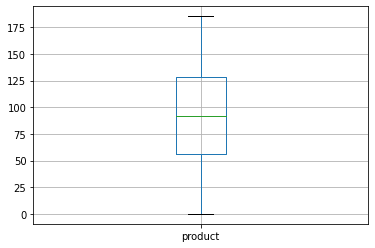

f0


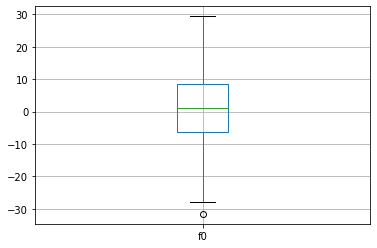

f1


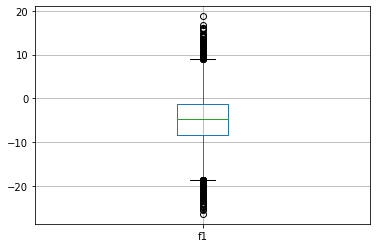

f2


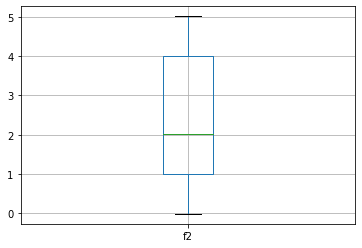

product


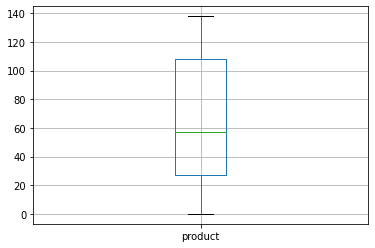

f0


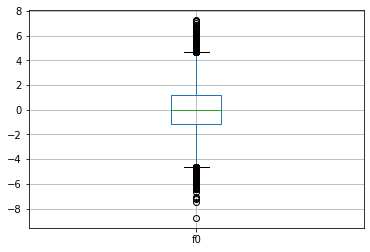

f1


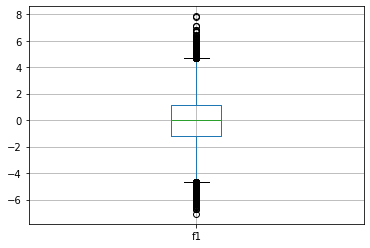

f2


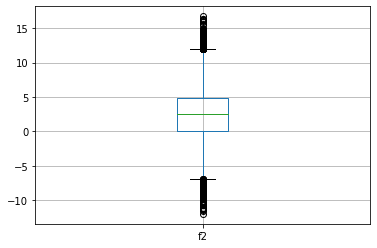

product


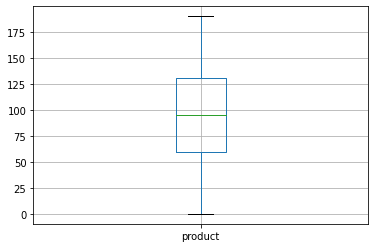

In [10]:
# Построение боксплотов для отслеживания выбросов
df_list = [geo_0,geo_1,geo_2]
par_list = ['f0','f1','f2','product']

for df in df_list:
    for par in par_list:
        print(par)
        df.boxplot(column =par)
        plt.show()

Выбросы есть, но не ошибки. Их не стоит удалять.

In [12]:
geo_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


###  Подготовка признаков и разделение данных

In [13]:
target_geo_0 = geo_0['product']
features_geo_0 = geo_0.drop('product',axis=1)

target_geo_1 = geo_1['product']
features_geo_1 = geo_1.drop('product',axis=1)

target_geo_2 = geo_2['product']
features_geo_2 = geo_2.drop('product',axis=1)

In [14]:
target_geo_0

0        105.280062
1         73.037750
2         85.265647
3        168.620776
4        154.036647
            ...    
99995    110.744026
99996    122.346843
99997     64.375443
99998     74.040764
99999    149.633246
Name: product, Length: 100000, dtype: float64

Разделим данные на выборки

In [15]:

features_train_geo_0, features_valid_geo_0,target_train_geo_0, target_valid_geo_0 = train_test_split(features_geo_0,target_geo_0,
                                                                             test_size = 0.25, 
                                                                             random_state=12345)

features_train_geo_1, features_valid_geo_1,target_train_geo_1, target_valid_geo_1 = train_test_split(features_geo_1,target_geo_1,
                                                                             test_size = 0.25, 
                                                                             random_state=12345)

features_train_geo_2, features_valid_geo_2,target_train_geo_2, target_valid_geo_2 = train_test_split(features_geo_2,target_geo_2,
                                                                             test_size = 0.25, 
                                                                             random_state=12345)


In [16]:
target_valid_geo_0

71751     10.038645
80493    114.551489
2655     132.603635
53233    169.072125
91141    122.325180
            ...    
12581    170.116726
18456     93.632175
73035    127.352259
63834     99.782700
43558    177.821022
Name: product, Length: 25000, dtype: float64

In [17]:
features_valid_geo_0

,f0,f1,f2
71751,0.948970,-0.057547,2.095727
80493,0.992974,0.206671,-0.142278
2655,1.199854,-0.563356,-1.852991
53233,0.691422,-0.433347,0.564974
91141,0.420772,0.972638,0.736190
...,...,...,...
12581,1.841106,-0.107678,2.585648
18456,0.041859,0.489280,2.168001
73035,0.376389,1.054298,-0.430104
63834,1.071330,-0.470046,4.527099


Масштабируем численные признаки

In [18]:
# масштабирование численных признаков

numeric = ['f0','f1','f2'] 

scaler = StandardScaler()
scaler.fit(features_train_geo_0[numeric])
features_train_geo_0[numeric] = scaler.transform(features_train_geo_0[numeric])
features_valid_geo_0[numeric] = scaler.transform(features_valid_geo_0[numeric])

scaler = StandardScaler()
scaler.fit(features_train_geo_1[numeric])
features_train_geo_1[numeric] = scaler.transform(features_train_geo_1[numeric])
features_valid_geo_1[numeric] = scaler.transform(features_valid_geo_1[numeric])


scaler = StandardScaler()
scaler.fit(features_train_geo_2[numeric])
features_train_geo_2[numeric] = scaler.transform(features_train_geo_2[numeric])
features_valid_geo_2[numeric] = scaler.transform(features_valid_geo_2[numeric])

## Обучение и проверка модели

In [21]:
fearures_list = [features_train_geo_0,features_train_geo_1,features_train_geo_2]

target_list = [target_train_geo_0,target_train_geo_1,target_train_geo_2]

target_valid_list = [target_valid_geo_0,target_valid_geo_1,target_valid_geo_2]
i = 0

for features,target,target_valid in zip(fearures_list,target_list,target_valid_list):
    
    model = LinearRegression().fit(features,target)
    predictions = model.predict(features)
    
    print('Регион', i)
    print('Средний запас предсказанного сырья: ', predictions.mean())
    print('Средний запас сырья регион 0: ', target_valid.mean())
    print('RMSE: ', mean_squared_error(target, predictions, squared=False))
    print()
    i+=1


Регион 0
Средний запас предсказанного сырья:  92.64046775305691
Средний запас сырья регион 0:  92.07859674082927
RMSE:  37.72999219904026

Регион 1
Средний запас предсказанного сырья:  68.85895465854665
Средний запас сырья регион 0:  68.72313602435997
RMSE:  0.8894720773917386

Регион 2
Средний запас предсказанного сырья:  95.03858906371522
Средний запас сырья регион 0:  94.88423280885438
RMSE:  40.06425978832384



Показатель rmse для моделей достаточно хорошие, особенно выделяется показатель для первого региона.

## Подготовка к расчёту прибыли

Подготовим константы, которые понадобятся в расчетах.

In [22]:
BUDGET = 10e9
UNIT_INCOME = 45*10e3
MAX_PROB = 0.025
NUMBER_WELLS_ALL = 500
NUMBER_WELLS = 200

print('Бюджет на разработку скважин в регионе', BUDGET)
print('Доход с каждой единицы продукта',UNIT_INCOME)
print('Максимальная вероятность убытков', MAX_PROB )
print('Всего скважин',NUMBER_WELLS_ALL)
print('Скважин к разработке',NUMBER_WELLS)

Бюджет на разработку скважин в регионе 10000000000.0
Доход с каждой единицы продукта 450000.0
Максимальная вероятность убытков 0.025
Всего скважин 500
Скважин к разработке 200


In [23]:
# Необходимый объем для 0 прибыли

BUDGET / UNIT_INCOME / 200

111.11111111111111

Судя по средним значением запасов сырья безубыточным возможно будет регион 2, возможно 0 тоже, а вот 1 вряд ли

## Расчёт прибыли и рисков 

### Расчёт прибыли

In [24]:
def revenue(df):
    return df.sum() * UNIT_INCOME

In [25]:
features_valid_list = [features_valid_geo_0,features_valid_geo_1,features_valid_geo_2]
target_valid_list = [target_valid_geo_0,target_valid_geo_1,target_valid_geo_2]
prediction_list = [[],[],[]]
i=0

for features_valid,target_valid in zip(features_valid_list, target_valid_list):
    
    predictions = model.predict(features_valid)
    prediction_list[i]=predictions
    predictions = pd.Series(predictions)
    
    geo_top = predictions.sort_values(ascending=False).head(200)

    target_valid_geo_top = target_valid.iloc[geo_top.index]
    
    print('Реальная прибыль для',i,'региона',revenue(target_valid_geo_top))
    print()
    
    
    i+=1


Реальная прибыль для 0 региона 12515937173.684607

Реальная прибыль для 1 региона 12201927868.477467

Реальная прибыль для 2 региона 12710349963.599833



###  Bootstrap

In [28]:
state = np.random.RandomState(12345)

In [29]:
prediction_list

[array([ 92.608829  ,  78.92397256,  68.61379951, ...,  77.00874105,
        107.50457535, 110.41585412]),
 array([100.88390304,  89.38918414,  77.62128855, ..., 124.14879483,
        100.94088035,  89.25399754]),
 array([ 93.59963303,  75.10515854,  90.06680936, ...,  99.40728116,
         77.77991248, 129.03241718])]

In [30]:
prediction_0 = pd.Series(prediction_list[0])
prediction_1 = pd.Series(prediction_list[1])
prediction_2 = pd.Series(prediction_list[2])

In [31]:
target_valid_geo_0 = target_valid_geo_0.reset_index(drop=True)
target_valid_geo_1 = target_valid_geo_1.reset_index(drop=True)
target_valid_geo_2 = target_valid_geo_2.reset_index(drop=True)


In [49]:
list_df = [target_valid_geo_0,target_valid_geo_1,target_valid_geo_2] 
pred_list = [prediction_0,prediction_1,prediction_2]


for target,prediction in zip(list_df,pred_list):
    values = []

    for i in range(1000):
        real_200 = []
        
        subsample_target = target.sample(n = 500, replace=False, random_state=state)    
        pred = prediction.iloc[subsample_target.index]        
        top_pred_200 =pred.sort_values(ascending=False).head(200)
        
        real_200 = subsample_target[top_pred_200.index]
        
        #print(real_200.duplicated().sum())#len(real_200))
        #real_200 = real_200.drop_duplicates()
        #print(real_200.duplicated().sum())#len(real_200))
        
        
        real_200 = pd.Series(real_200)
        #print(real_200.size)
        #print()
        rev = revenue(real_200) - BUDGET
        values.append(rev)

   
    values = pd.Series(values)
    waste = values.loc[values < 0]

    mean = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    max_waste = waste.min()
    prob_waste = (values < 0).mean()

    print('2.5% квантиль:',lower)
    print('97.5% квантиль:',upper)
    print('Средняя выручка:',mean)
    print('Количество убыточных скважин:',len(waste))
    print('Вероятность убытка',prob_waste)
    print()

2.5% квантиль: -261801615.9744963
97.5% квантиль: 747023373.9086686
Средняя выручка: 238061064.87789458
Количество убыточных скважин: 188
Вероятность убытка 0.188

2.5% квантиль: 37931918.370180815
97.5% квантиль: 815387847.8541434
Средняя выручка: 425155860.0466862
Количество убыточных скважин: 17
Вероятность убытка 0.017

2.5% квантиль: -155876262.87190527
97.5% квантиль: 908273829.9453012
Средняя выручка: 397204398.5228207
Количество убыточных скважин: 77
Вероятность убытка 0.077



Наименьшая вероятность уйти в убыток при разроботке скавжин в 1 регионе,вероятность убытка в других регионах (0,2) выше.   
По результатам исследование рекомендовали бы 1 регион.

In [ ]:
# Старый вариант
list_df = [target_valid_geo_0,target_valid_geo_1,target_valid_geo_2] 

for df in list_df:
    values = []

    for i in range(1000):
        subsample = df.sample(n = 500, replace=True, random_state=state)
        subsample_top = subsample.sort_values(ascending=False).head(200)
        rev = revenue(subsample_top) 
        values.append(rev)


    values = pd.Series(values)
    waste = values.loc[values < 0]

    mean = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    max_waste = waste.min()
    prob_waste = (values < 0).mean()

    print('2.5% квантиль:',lower)
    print('97.5% квантиль:',upper)
    print('Средняя выручка:',mean)
    print('Количество убыточных скважин:',len(waste))
    print()
    print()

По полученым результатам предпочтительней разрабатывать 2 регион (geo_2): наибольшая среднее по распределению выручки и малое количество убыточных вариантов.


- Средняя выручка: 425155860.0466862
- Количество убыточных скважин: 17
- Вероятность убытка 0.017 ~ 2% 

`В процессе исследования:`
1. Загружены и подготовлены данные. 
2. Обучены и проверены модели для каждого региона
3. Проведена подготовка к расчёту прибыли
4. Написана функция для расчёта прибыли по выбранным скважинам и предсказаниям модели
5. Расчитаны риски и прибыль для каждого региона
6. Вывод